In [ ]:
last_index = submissions_df[submissions_df['id'] == '3s0obx'].index[0] + 1
print(last_index)
submissions_df['id'][last_index:].values

# Problem Statement

## Table of Contents
- [Data Cleaning](#Data-Cleaning)
    - [Submissions](#Submissions)
    - [Comments](#Comments)
    - [Users](#Users)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Submissions](#Submissions-EDA)
    - [Comments](#Comments-EDA)
    - [Users](#Users-EDA)
- [Modeling](#Modeling)
- [Results & Conclusions](#Results-&-Conclusions)

### Imports

In [1]:
import configparser
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from aws_mysql import MySqlConn
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### Functions

In [142]:
def bool_to_int(df_o, bool_cols):
    """
    Takes a DataFrame and list of boolean columns and maps the boolean values
    to integers. Does not work with strings.
    :param: Pandas DataFrame.
    :param: List of column names of booleans.
    :return: Pandas DataFrame.
    """
    bool_func = lambda x: 1 if x else 0
    df_ = df_o.copy()
    for col in bool_cols:
        df_[col] = df_[col].map(bool_func)
    return df_
    
# Dates ---------------------------------------------------------------------
# year and month are false as the spread of days we are looking at is 11 days
def convert_epoch(df_o, epoch_col, 
                  year=False, month=False, dayofweek=True, hour=True):
    """
    Takes a the DataFrame and converts a column of epoch datetime to a
    datetime object. The original column is dropped and a new column
    'created_date' is added to the dataframe. 
    :param df_: Pandas DataFrame with a column of datetime in epoch format.
    :param epoch_col: Name of column with epoch datetime.
    :param year: Boolean Optional (Default True), whether a 'year' column is 
    created. 
    :param month: Boolean Optional (Default True), whether a 'month' column is
    created.
    :param dayofweek: Boolean Optional (Default True), whether a 'day_of_week'
    column is created.
    :param hour: Boolean Optional (Default True), whether a 'hour' column is
    created.
    :return: Pandas DataFrame.
    """
    df_ = df_o.copy()
    df_['created_date'] = pd.to_datetime(df_[epoch_col], unit='s')
    
    if year:
        df_['created_year'] = df_['created_date'].dt.year
    if month:
        df_['created_month'] = df_['created_date'].dt.month
    if dayofweek:
        df_['created_day_of_week'] = df_['created_date'].dt.dayofweek
    if hour:
        df_['created_hour'] = df_['created_date'].dt.hour
    
    return df_

# NLP -----------------------------------------------------------------------
def clean_submission_df(df_o):
    """
    Takes DataFrame and drops na values, duplicates, empty 'selftext' columns,
    and pinned content.
    :param df_o: pandas Dataframe to clean.
    :return: pandas DataFrame.
    """
    df_ = df_o.copy()
    df_.dropna(inplace=True)  # cannot fix na values of selftext
    df_.drop_duplicates(subset=['id'], inplace=True)  # init check
    df_ = df_[~df_['selftext'].isin(['[deleted]', '[removed]'])]
    df_ = df_[~df_['pinned']]  # pinned content is most likely rules/faq/etc
    return df_


# cleans text using all cleaning functions
def clean_text(X, word_list=[]):
    """
    
    """
    # order is very important
    X = replace_url(X)
    X = replace_amp(X)
    X = replace_nbsp(X)
    X = replace_newline(X)
    X = replace_nonalpha(X)
    X = replace_small_words(X)
    X = remove_words(X, word_list)
    return X


def replace_url(X):
    """
    Takes pandas series of text and removes urls.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('http\S+|www.\S+', '', case=False)  # ref 1


def replace_amp(X):
    """
    Takes pandas series of text and removes '&'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('&amp;', ' ', regex=False)


def replace_nbsp(X):
    """
    Takes pandas series of text and removes 'nbsp'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('nbsp;', ' ', regex=False)


def replace_newline(X):
    """
    Takes pandas series of text and removes '\n'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('\n', ' ', regex=False)


def replace_nonalpha(X):
    """
    Takes pandas series of text and non alpha characters.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('[^a-zA-Z ]', ' ')  # ref 2 


def replace_small_words(X):
    """
    Takes pandas series of text and removes words below 4 characters.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace(r'\b[a-zA-Z]{1,3}\b', '')  # ref 3


def remove_words(X, words=[]):
    """
    Takes pandas series of text and removes `words`.
    :param X: Pandas series.
    :param words: List of strings, words to be removed from text 
    (case sensitive).
    :return: Pandas series.
    """
    for word in words:
        X = X.str.replace(word, '')
    return X

## Data

In [3]:
# get data from AWS rds
config = configparser.ConfigParser()
config.read('./config.ini')

db = MySqlConn(endpoint = config['rds']['endpoint'], 
               user     = config['rds']['user'], 
               password = config['rds']['password'], 
               dbname   = config['rds']['dbname'])

db.connect()

comments_df = pd.read_sql("""SELECT * FROM comments""", db.conn)
users_df    = pd.read_sql("""SELECT * FROM users""", db.conn)

db.close()

In [4]:
submissions_df = pd.read_csv('./data/submissions.csv')

C:\Users\Sam\anaconda3\envs\ga-dsir-capstone\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,21,33,36,37,39,40,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,77,79,81,82,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,117,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning

Purpose:
* Drop Features that are not helpful.
* Impute or remove null values

### Submissions

In [5]:
submissions_df.shape

(86657, 122)

**Selftext**

In [6]:
submissions_df['selftext'].isna().sum() / submissions_df.shape[0]

0.4170465167268657

41.7+ percent of the `selftext` of submissions are blank. There could be many reasons for this:
- Might be media of some sort: image, video
- Could be link to article/content on another website
- All necessary text fit into the title

Fill null `selftext` with a blank string, `''`. No other way to impute values.

In [7]:
submissions_df['selftext'].fillna('', inplace=True)

**Select Columns**  
Automatically drop columns with greater than 50% null values as `selftext` is missing ~42%. Also looked through columns manually to add to keep_cols if they seem useful.

In [8]:
drop_cols = submissions_df.columns[submissions_df.isna().sum() / submissions_df.shape[0] > 0.50].values
drop_cols = set(drop_cols)

submissions_df.drop(columns=(drop_cols)).columns

Index(['author', 'author_fullname', 'created_utc', 'domain', 'full_link', 'id',
       'is_self', 'locked', 'media_embed', 'num_comments', 'over_18',
       'permalink', 'retrieved_on', 'score', 'secure_media_embed', 'selftext',
       'stickied', 'subreddit', 'subreddit_id', 'thumbnail', 'title', 'url',
       'search_term', 'period'],
      dtype='object')

In [9]:
# reviewed all columns and decided on this list
keep_cols = [
    'author',
    'created_utc', 
    'domain', 
    'id',
    'is_self',
    'num_comments', 
    'over_18',
    'score', 
    'selftext',
    'stickied', 
    'subreddit', 
    'thumbnail', 
    'title',
    'promoted',
    'search_term', 
    'period',
    'full_link'
]

In [10]:
submissions_df = submissions_df[keep_cols]

**Check for Null Values for Selected Columns**

In [11]:
submissions_df.isna().sum() / submissions_df.shape[0]

author          0.000012
created_utc     0.000000
domain          0.000035
id              0.000000
is_self         0.000000
num_comments    0.000000
over_18         0.000000
score           0.000000
selftext        0.000000
stickied        0.054502
subreddit       0.000992
thumbnail       0.000012
title           0.000000
promoted        0.994542
search_term     0.000000
period          0.000000
full_link       0.000000
dtype: float64

In [12]:
submissions_df.describe()

,created_utc,num_comments,score
count,8.665700e+04,86657.000000,86657.000000
mean,1.507940e+09,14.525139,16.037804
std,9.230622e+07,130.187858,171.480920
min,1.284756e+09,-3.000000,0.000000
25%,1.447190e+09,0.000000,1.000000
50%,1.463432e+09,2.000000,1.000000
75%,1.607565e+09,7.000000,1.000000
max,1.612742e+09,16057.000000,9631.000000


**Number of Comments**  
Replace negative number of comments with 0.

In [13]:
submissions_df[submissions_df['num_comments'] < 0] = 0

**Author**  
`author_fullname` and `author_id` columns are also null when `author` is null.

In [14]:
submissions_df[submissions_df['author'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link
68237,NaN,1.302772e+09,gameshampoo.com,gps20,False,50.0,False,0.0,,NaN,promos,http://thumbs.reddit.com/t3_gps20.png?v=d26045...,Win a free copy of Portal 2!,True,Portal 2,pre launch,https://www.reddit.com/comments/gps20/win_a_fr...


Assuming that if `author` is null then it is equivalent to `'[deleted]'`

In [15]:
submissions_df['author'].fillna('[deleted]', inplace=True)
submissions_df['author_deleted'] = submissions_df['author']\
                                    .map(lambda x: 1 
                                         if x == '[deleted]' 
                                         else 0)

In [16]:
submissions_df['author_deleted'].value_counts()

0    78183
1     8474
Name: author_deleted, dtype: int64

**Domain**

In [17]:
submissions_df[submissions_df['domain'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
78364,feathand,1.584221e+09,NaN,fipqxs,False,0.0,False,1.0,,False,Metal,default,Music Similiar to Doom (2016) and Doom Eternal...,NaN,DOOM Eternal,pre launch,https://www.reddit.com/r/Metal/comments/fipqxs...,0
83248,zitping,1.584839e+09,NaN,fmr2o1,False,4.0,False,1.0,,False,Doom,default,[Troubleshooting] Doom Eternal - Constant cras...,NaN,DOOM Eternal,post launch,https://www.reddit.com/r/Doom/comments/fmr2o1/...,0
83450,Xenix1252,1.584852e+09,NaN,fmu6uk,False,5.0,False,1.0,,False,Doom,spoiler,Samuel Hayden and his role in the story of the...,NaN,DOOM Eternal,post launch,https://www.reddit.com/r/Doom/comments/fmu6uk/...,0


In [18]:
submissions_df['domain']

0              self.Fallout
1         self.pcmasterrace
2              self.Fallout
3                  self.fo4
4               youtube.com
                ...        
86652    self.buildapcforme
86653        self.GamerPals
86654         self.Trophies
86655     self.CrackSupport
86656     self.pcmasterrace
Name: domain, Length: 86657, dtype: object

`is_self` is False, unsure how to impute, so drop rows.

**Stickied**

In [19]:
submissions_df['stickied'].value_counts()

False    81866
True        70
Name: stickied, dtype: int64

In [20]:
submissions_df[submissions_df['stickied'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
67260,ghkjdfhgjsdhgjklfhjk,1.313025e+09,self.gaming,jf77c,True,7.0,False,3.0,I'm torn.,NaN,gaming,self,Bastion or From Dust?,NaN,Bastion,pre launch,https://www.reddit.com/r/gaming/comments/jf77c...,0
67261,masamagic,1.313026e+09,self.tf2trade,jf7qj,True,0.0,False,0.0,"Trading Bills, V. Whiskers and some other hats...",NaN,tf2trade,self,"[W] Bastion [H] Bill's, V Whiskers + More",NaN,Bastion,pre launch,https://www.reddit.com/r/tf2trade/comments/jf7...,0
67262,[deleted],1.313030e+09,self.SteamGameSwap,jf9qc,True,0.0,False,1.0,,NaN,SteamGameSwap,default,"[H] Amnesia: Dark Decent, Audiosurf, Day of De...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,1
67263,buggereet,1.313031e+09,self.SteamGameSwap,jfa9c,True,0.0,False,1.0,,NaN,SteamGameSwap,self,"[H] Audiosurf, Cogs, Portal (pick two) [W] Bas...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,0
67264,[deleted],1.313046e+09,self.SteamGameSwap,jfgtf,True,0.0,False,1.0,Just want to put out there that I am not inter...,NaN,SteamGameSwap,default,"[H] Terraria, LIMBO, Beat Hazard Complete [W] ...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72521,OysterTwister,1.303602e+09,youtube.com,gw011,False,0.0,False,2.0,,NaN,reddit.com,default,The Best Gamers review Portal 2 (SPOILERS),NaN,Portal 2,post launch,https://www.reddit.com/r/reddit.com/comments/g...,0
72522,[deleted],1.303602e+09,i.imgur.com,gw028,False,0.0,False,1.0,,NaN,gaming,default,"It's no Portal 2, but does anyone else miss pl...",NaN,Portal 2,post launch,https://www.reddit.com/r/gaming/comments/gw028...,1
72523,Mallack,1.303602e+09,i.imgur.com,gw03q,False,6.0,False,0.0,,NaN,gaming,http://thumbs.reddit.com/t3_gw03q.png,Why couldn't he be a Co-op partner in Portal 2?,NaN,Portal 2,post launch,https://www.reddit.com/r/gaming/comments/gw03q...,0
72524,Stalked_Like_Corn,1.303602e+09,self.Portal,gw04g,True,3.0,False,1.0,So I got Portal 2 and want to do Co-Op but all...,NaN,Portal,self,LF Portal 2 Co-Op buddy. Inquire within,NaN,Portal 2,post launch,https://www.reddit.com/r/Portal/comments/gw04g...,0


There are only 70 total stickied submissions vs the 81,864 non-stickied. Additionally, the no clear way to check if null values were sticked or not. So, drop the column.

In [21]:
submissions_df.drop(columns='stickied', inplace=True)

**Subreddit**

In [22]:
submissions_df[submissions_df['subreddit'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
133,[deleted],1.446605e+09,rareitemapparel.com,3rfx7v,False,0.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/KS4dX5huaXN0z2...,How I feel waiting for Fallout 4...,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rfx7v/how_i_f...,1
1503,SickAcorn,1.446701e+09,twitch.tv,3rleos,False,0.0,False,1.0,,NaN,default,Fallout 4 stream,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rleos/fallout...,0
1862,LERAGESHIRTS,1.446736e+09,lerageshirts.com,3rmwzr,False,1.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/ywNvlxU8A6IJzm...,In case you need this for the 400 hours of gam...,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rmwzr/in_case...,0
8485,redditads,1.447135e+09,redbox.com,3s8nwi,False,146.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/qBWq8Bt-YaF38q...,"Gaming on a budget? For just $3 a day, you can...",True,Fallout 4,post launch,https://www.reddit.com/comments/3s8nwi/gaming_...,0
8504,redditads,1.447135e+09,redbox.com,3s8of5,False,134.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/FFndVjpp_jctnv...,"Gaming on a budget? For just $3 a day, you can...",True,Fallout 4,post launch,https://www.reddit.com/comments/3s8of5/gaming_...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63858,2game_com,1.506755e+09,2game.com,73dleg,False,0.0,False,1.0,,NaN,https://a.thumbs.redditmedia.com/ht_34vnI81g3t...,Total War: WARHAMMER II + Bonus Norsca Race DL...,True,Total War: WARHAMMER II,post launch,https://www.reddit.com/comments/73dleg/total_w...,0
73577,cdkeyscom,1.462978e+09,cdkeys.com,4iv8ib,False,36.0,False,18.0,,NaN,http://b.thumbs.redditmedia.com/_WfwJzTiYKIMi2...,"Hello Marines, we've got DOOM PC at a huge dis...",True,DOOM,pre launch,https://www.reddit.com/comments/4iv8ib/hello_m...,0
73908,jakequade,1.463116e+09,finder.com.au,4j4tb9,False,0.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/Aq-SKyfYYh3q8Z...,Chainsaw carver sculpts 8-foot DOOM Revenant s...,True,DOOM,post launch,https://www.reddit.com/comments/4j4tb9/chainsa...,0
76240,EpicFred,1.463325e+09,g2a.com,4jghgs,False,2.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/bOadiOyIWVwPdU...,"Hey everyone! My name is James, I recently bec...",True,DOOM,post launch,https://www.reddit.com/comments/4jghgs/hey_eve...,0


Looking at the `full_link` it seems as if these are not actual submissions. When clicking the page it leads to a page with no comments, title, or self text. It would be best to drop these rows.

**Thumbnail**

In [23]:
submissions_df[submissions_df['thumbnail'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
53706,[deleted],1.285188e+09,guardian.co.uk,dhiky,False,0.0,False,1.0,,gaming,NaN,Review: Sid Meier's Civilization V,NaN,Sid Meier's Civilization® V,post launch,https://www.reddit.com/r/gaming/comments/dhiky...,1


In [24]:
submissions_df['thumbnail'].value_counts()

self                                                                                41040
default                                                                             18372
nsfw                                                                                 1847
spoiler                                                                              1180
image                                                                                 636
                                                                                    ...  
https://a.thumbs.redditmedia.com/AvNI_zeGfgjiQA6FrQo_yCHSCfMyf5Iag9uWr6AKAT0.jpg        1
https://b.thumbs.redditmedia.com/GGOheck97XisbIGfrq6THmQnXgEZwaMdUO1nL7vlHWs.jpg        1
http://b.thumbs.redditmedia.com/rCVTrPhhBUX0cX3KsARjfvVz7wa1ybo1XMtb3ejHqus.jpg         1
https://b.thumbs.redditmedia.com/v2gytE5HY49N04cEaUSt8nLCGiQyCULKi_j4ydp47oU.jpg        1
http://thumbs.reddit.com/t3_guvxs.png                                                   1
Name: thum

**Promoted**

In [25]:
submissions_df['promoted'].value_counts()

True    473
0         2
Name: promoted, dtype: int64

Since there are no `False` values for promoted, assume null value are false.

In [26]:
submissions_df['promoted'].fillna(False, inplace=True)

**Final Cleanup**

In [27]:
submissions_df.isna().sum()

author             0
created_utc        0
domain             3
id                 0
is_self            0
num_comments       0
over_18            0
score              0
selftext           0
subreddit         86
thumbnail          1
title              0
promoted           0
search_term        0
period             0
full_link          0
author_deleted     0
dtype: int64

In [28]:
print(submissions_df.shape)
submissions_df.dropna(inplace=True)
print(submissions_df.shape)

(86657, 17)
(86567, 17)


### Comments

In [29]:
comments_df.shape

(138129, 12)

In [30]:
comments_df.head()

,CommentID,AuthorID,Body,CreatedUTC,Distinguished,Edited,IsSubmitter,LinkID,ParentID,Score,Stickied,SubredditID
0,cwnj5aq,5u01v,1. Yes you should be able to run at ultra.\n2....,1446595365,0.0,0,0,t3_3rf9yg,t3_3rf9yg,2,0,t5_2sgp1
1,cwnj5cs,axyl0,Your gonna have to wait till the game comes ou...,1446595368,0.0,0,0,t3_3rf9yg,t3_3rf9yg,1,0,t5_2sgp1
2,cwnj5tv,lc8hr,1. Probably.\n2. N/A\n3. Wait for the sale.,1446595389,0.0,0,0,t3_3rf9yg,t3_3rf9yg,0,0,t5_2sgp1
3,cwnj8h9,db1a5,"Alright, thank you!",1446595507,0.0,0,1,t3_3rf9yg,t1_cwnj5aq,1,0,t5_2sgp1
4,cwnj8jz,7tb54,https://www.youtube.com/watch?v=OyJbSxpjrf8\n\...,1446595510,0.0,0,0,t3_3rfaem,t3_3rfaem,1,0,t5_2qnzu


In [31]:
comments_df.isna().sum() / comments_df.shape[0]

CommentID        0.000000
AuthorID         0.164998
Body             0.000000
CreatedUTC       0.000000
Distinguished    0.719226
Edited           0.000000
IsSubmitter      0.000000
LinkID           0.000000
ParentID         0.000000
Score            0.000000
Stickied         0.000000
SubredditID      0.000000
dtype: float64

In [32]:
useless_cols = []
for col in comments_df.columns:
    if len(comments_df[col].value_counts()) < 2:
        useless_cols.append(col)
useless_cols

['Distinguished', 'Stickied']

**AuthorID**

If there is no author id the account was deleted.  
Author id will be used to count number of comments per author.  

In [33]:
comments_df['AuthorID'].value_counts()

6l4z3    251
in4c5    240
e4enr    230
olhq8    157
euyo5    137
        ... 
5kw10      1
is28x      1
kghlw      1
78bdg      1
3xnmi      1
Name: AuthorID, Length: 48330, dtype: int64

In [124]:
comments_df['has_author'] = comments_df['AuthorID'].map(lambda x: 1 
                                                        if x else 0)
comments_df['has_author'].value_counts(normalize=True)

1    0.835002
0    0.164998
Name: has_author, dtype: float64

**Distinguished**

In [35]:
comments_df['Distinguished'].value_counts()

0.0    38783
Name: Distinguished, dtype: int64

`Distinguished` feature is either False or null. Seems best to just drop the column.

In [36]:
comments_df.drop(columns='Distinguished', inplace=True)

**Stickied**

In [37]:
comments_df['Stickied'].value_counts()

0    138129
Name: Stickied, dtype: int64

Seems wrong but no `Stickied` comments, drop `Stickied` column.

In [38]:
comments_df.drop(columns='Stickied', inplace=True)

### Users

In [39]:
users_df.shape

(48326, 9)

In [40]:
users_df.head()

,UserID,CommentKarma,CreatedUTC,VerifiedEmail,IsEmployee,IsMod,IsGold,LinkKarma,Name
0,11r6v,109958,1170109022,1.0,0,1,0,2608,apullin
1,12kj8,248529,1170444518,1.0,0,0,1,28625,antillus
2,12tkh,108198,1170611837,1.0,0,1,0,48457,THEMACGOD
3,139sx,81138,1170827928,1.0,0,0,0,5823,puttysan
4,13vj2,46809,1171137029,1.0,0,1,0,5203,andrejevas


In [41]:
users_df.isna().sum()

UserID             0
CommentKarma       0
CreatedUTC         0
VerifiedEmail    224
IsEmployee         0
IsMod              0
IsGold             0
LinkKarma          0
Name               0
dtype: int64

**VerifiedEmail**

In [42]:
users_df['VerifiedEmail'].value_counts()

1.0    40691
0.0     7411
Name: VerifiedEmail, dtype: int64

In [43]:
users_df.dropna(inplace=True)

## Exploratory Data Analysis

### Dates  
Convert epoch dates to datetime and pull out the Year, Month, Day of Week, and Hour.

In [44]:
submissions_df = convert_epoch(submissions_df, 'created_utc')
comments_df = convert_epoch(comments_df, 'CreatedUTC')
users_df = convert_epoch(users_df, 'CreatedUTC')

### Submissions EDA  


In [45]:
submissions_df.head()

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted,created_date,created_day_of_week,created_hour
0,watisdisanywais,1.446595e+09,self.Fallout,3rf9t3,True,13.0,False,0.0,"Well guys, out of curiosity, I called my local...",Fallout,self,Picking up your copy early,False,Fallout 4,pre launch,https://www.reddit.com/r/Fallout/comments/3rf9...,0,2015-11-04 00:00:07,2,0
1,fatyg5,1.446595e+09,self.pcmasterrace,3rf9yg,True,13.0,False,0.0,1. Will my PC run it decently well? Important ...,pcmasterrace,self,Fallout 4 Questions,False,Fallout 4,pre launch,https://www.reddit.com/r/pcmasterrace/comments...,0,2015-11-04 00:01:01,2,0
2,Rodolfo619,1.446595e+09,self.Fallout,3rfaem,True,10.0,False,0.0,I'm planning on buying fallout 4 but I've neve...,Fallout,self,Noob question regarding the lore/story of the ...,False,Fallout 4,pre launch,https://www.reddit.com/r/Fallout/comments/3rfa...,0,2015-11-04 00:04:22,2,0
3,INBREEDCLOWN,1.446596e+09,self.fo4,3rfai7,True,0.0,False,1.0,[removed],fo4,default,M1 Garand in fallout 4,False,Fallout 4,pre launch,https://www.reddit.com/r/fo4/comments/3rfai7/m...,0,2015-11-04 00:05:05,2,0
4,pyjamapants8,1.446596e+09,youtube.com,3rfame,False,2.0,False,4.0,,VGCovers,http://b.thumbs.redditmedia.com/WZv98MQXwi13jP...,Fallout 4 - Main Theme [Cover] - 'War Never Ch...,False,Fallout 4,pre launch,https://www.reddit.com/r/VGCovers/comments/3rf...,0,2015-11-04 00:05:47,2,0


In [46]:
submissions_df.describe()

,created_utc,num_comments,score,author_deleted,created_day_of_week,created_hour
count,8.656700e+04,86567.000000,86567.000000,86567.000000,86567.000000,86567.000000
mean,1.507930e+09,14.534823,16.052884,0.097855,3.148763,12.492439
std,9.262344e+07,130.253320,171.569382,0.297120,1.922842,7.232351
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.447190e+09,0.000000,1.000000,0.000000,1.000000,6.000000
50%,1.463430e+09,2.000000,1.000000,0.000000,3.000000,14.000000
75%,1.607565e+09,7.000000,1.000000,0.000000,5.000000,19.000000
max,1.612742e+09,16057.000000,9631.000000,1.000000,6.000000,23.000000


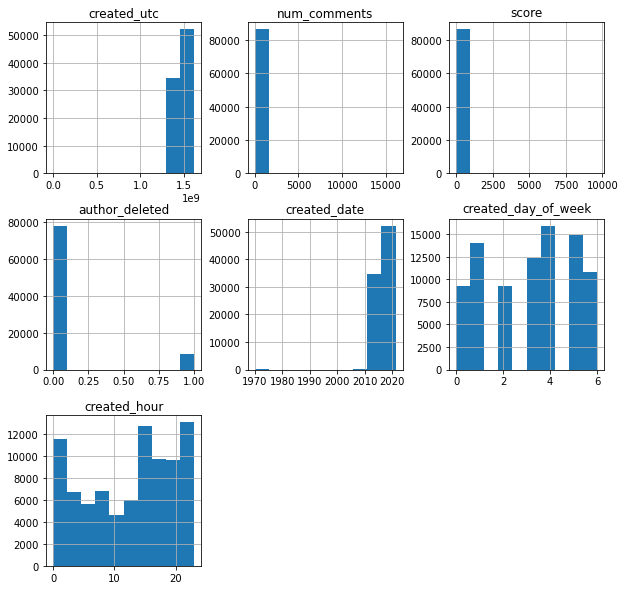

In [47]:
submissions_df.hist(figsize=(10, 10))
plt.tight_layout;

In [121]:
submissions_df.groupby(by='created_day_of_week').mean().T

created_day_of_week,0,1,2,3,4,5,6
created_utc,1.570243e+09,1.470062e+09,1.439982e+09,1.513651e+09,1.516470e+09,1.513106e+09,1.535674e+09
num_comments,1.791634e+01,1.252932e+01,1.447891e+01,1.746991e+01,1.441979e+01,1.259376e+01,1.378308e+01
score,8.542528e+00,1.540613e+01,2.621551e+01,1.639107e+01,1.751123e+01,1.578127e+01,1.247650e+01
author_deleted,2.411714e-02,1.410393e-01,1.624420e-01,9.866017e-02,9.106314e-02,9.493373e-02,6.279435e-02
created_hour,1.310950e+01,1.242020e+01,1.247072e+01,1.188031e+01,1.268526e+01,1.227390e+01,1.278798e+01


In [48]:
submissions_df.groupby(by='domain').mean()

,created_utc,num_comments,score,author_deleted,created_day_of_week,created_hour
domain,,,,,,
0,0.000000e+00,0.0,0.0,0.0,3.0,0.0
/comments/brv5gp/only_strength_can_rule_only_fools_think_otherwise/,1.558564e+09,1.0,10.0,0.0,2.0,22.0
/comments/brv60q/do_you_have_what_it_takes_to_unite_china_and/,1.558564e+09,0.0,11.0,0.0,2.0,22.0
/comments/brv6wr/do_you_have_what_it_takes_to_unite_china_and/,1.558564e+09,2.0,12.0,0.0,2.0,22.0
/comments/brv7dv/only_strength_can_rule_only_fools_think_otherwise/,1.558564e+09,1.0,9.0,0.0,2.0,22.0
...,...,...,...,...,...,...
zakodia.deviantart.com,1.363980e+09,0.0,6.5,0.5,4.0,18.5
zam.com,1.460588e+09,4.0,14.0,0.0,2.0,22.0
zappinternet.com,1.302907e+09,1.0,0.0,1.0,4.0,22.0


In [122]:
submissions_df.columns

Index(['author', 'created_utc', 'domain', 'id', 'is_self', 'num_comments',
       'over_18', 'score', 'selftext', 'subreddit', 'thumbnail', 'title',
       'promoted', 'search_term', 'period', 'full_link', 'author_deleted',
       'created_date', 'created_day_of_week', 'created_hour'],
      dtype='object')

In [135]:
def join_text(series):
    return lambda x: ' '.join(x)

submissions_df.groupby(by='author').agg({
    'is_self': 'mean',
    'num_comments': 'mean',
    'score': 'mean',
    'selftext': lambda x: ' '.join(x),
    'subreddit': lambda x: ' '.join(x),
    'title': lambda x: ' '.join(x)
})

DataError: No numeric types to aggregate

### Comments EDA

In [125]:
comments_df.columns

Index(['CommentID', 'AuthorID', 'Body', 'CreatedUTC', 'Edited', 'IsSubmitter',
       'LinkID', 'ParentID', 'Score', 'SubredditID', 'has_author',
       'created_date', 'created_day_of_week', 'created_hour', 'body_length'],
      dtype='object')

In [126]:
comments_df['body_length'] = comments_df['Body'].apply(lambda x: len(x))

In [127]:
comments_df.describe()

,CreatedUTC,Edited,IsSubmitter,Score,has_author,created_day_of_week,created_hour,body_length
count,1.381290e+05,138129.000000,138129.000000,138129.000000,138129.000000,138129.000000,138129.000000,138129.000000
mean,1.446843e+09,4.512564,0.054572,5.492257,0.835002,3.853304,12.391504,137.347842
std,4.540854e+05,23.510347,0.227144,47.426538,0.371180,1.483871,7.302182,252.040316
min,1.446595e+09,0.000000,0.000000,-214.000000,0.000000,0.000000,0.000000,0.000000
25%,1.446725e+09,0.000000,0.000000,1.000000,1.000000,3.000000,5.000000,25.000000
50%,1.446810e+09,0.000000,0.000000,1.000000,1.000000,4.000000,14.000000,69.000000
75%,1.446933e+09,0.000000,0.000000,2.000000,1.000000,5.000000,19.000000,155.000000
max,1.557539e+09,127.000000,1.000000,5792.000000,1.000000,6.000000,23.000000,9997.000000


In [58]:
comments_df['body_length'].mean(), comments_df['body_length'].std()

(137.3478415104721, 252.04031554688527)

In [129]:
comments_df['Edited'].value_counts(normalize=True)

0      0.964468
127    0.035532
Name: Edited, dtype: float64

In [130]:
comments_df['IsSubmitter'].value_counts(normalize=True)

0    0.945428
1    0.054572
Name: IsSubmitter, dtype: float64

### Users EDA
* TODO parse out bots

In [65]:
users_df.head()

,UserID,CommentKarma,CreatedUTC,VerifiedEmail,IsEmployee,IsMod,IsGold,LinkKarma,Name,created_date,created_day_of_week,created_hour
0,11r6v,109958,1170109022,1.0,0,1,0,2608,apullin,2007-01-29 22:17:02,0,22
1,12kj8,248529,1170444518,1.0,0,0,1,28625,antillus,2007-02-02 19:28:38,4,19
2,12tkh,108198,1170611837,1.0,0,1,0,48457,THEMACGOD,2007-02-04 17:57:17,6,17
3,139sx,81138,1170827928,1.0,0,0,0,5823,puttysan,2007-02-07 05:58:48,2,5
4,13vj2,46809,1171137029,1.0,0,1,0,5203,andrejevas,2007-02-10 19:50:29,5,19


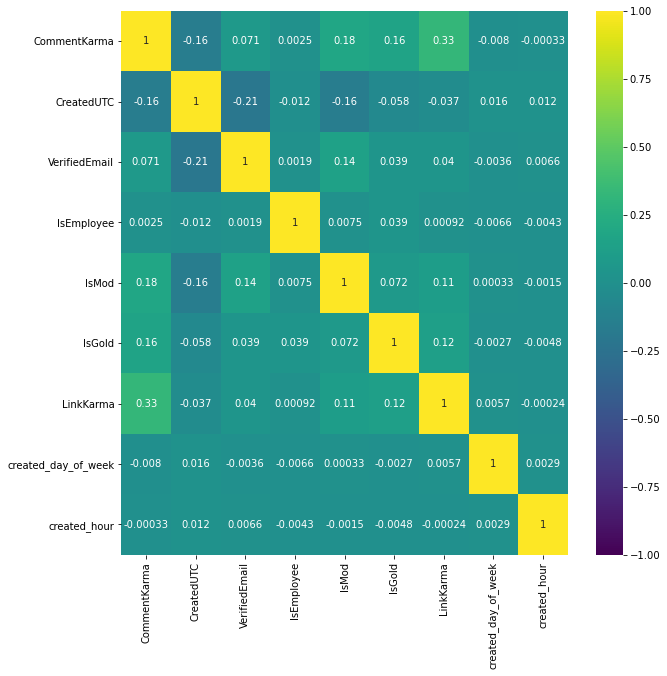

In [66]:
plt.figure(figsize=(10, 10))
sns.heatmap(users_df.corr(), vmax=1, vmin=-1, annot=True, cmap='viridis');

In [67]:
users_df['VerifiedEmail'].value_counts(normalize=True)

1.0    0.845932
0.0    0.154068
Name: VerifiedEmail, dtype: float64

In [68]:
users_df['IsMod'].value_counts(normalize=True)

0    0.7292
1    0.2708
Name: IsMod, dtype: float64

In [69]:
users_df['IsEmployee'].value_counts(normalize=True)

0    0.999979
1    0.000021
Name: IsEmployee, dtype: float64

In [70]:
users_df['IsGold'].value_counts(normalize=True)

0    0.986633
1    0.013367
Name: IsGold, dtype: float64

**Notes:**  
Exclude `IsEmployee` and `IsGold` as most of the users are `False`

In [140]:
users_df.drop(columns=['IsEmployee', 'IsGold'], inplace=True)

In [74]:
users_df['name_length'] = users_df['Name'].map(lambda x: len(x))

## Final Datasets

**Submissions Data Dictionary**

|Feature|type|Dataset|Description|
| :--- | :--- | :--- | :--- |
|author|||
|created_utc|||
|submission_id|||
|num_comments|||
|score|||
|selftext|||
|subreddit|||
|title|||
|distinguished|||

## Modeling  
Selected DBSCAN as the main clustering model for the following reasons:
* Keeping all outliers.
* 

In [96]:
X = users_df[[
    'CommentKarma',
    'VerifiedEmail', 
    'IsMod',
    'LinkKarma',
#     'created_date',
    'name_length'
]].values

In [97]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [98]:
X_scaled

array([[ 0.95588817,  0.42676542,  1.64096566, -0.08846268, -1.00817198],
       [ 2.62772579,  0.42676542, -0.60939727,  0.43947839, -0.71496782],
       [ 0.93465405,  0.42676542,  1.64096566,  0.84191246, -0.42176366],
       ...,
       [-0.02873588,  0.42676542,  1.64096566, -0.10252515, -1.30137614],
       [ 0.69125787,  0.42676542, -0.60939727,  0.09449141, -0.71496782],
       [-0.04515613,  0.42676542,  1.64096566, -0.11967202, -1.00817198]])

In [99]:
dbscan = DBSCAN(eps=.65, min_samples=6)
dbscan.fit(X_scaled)

DBSCAN(eps=0.65, min_samples=6)

In [100]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4}

In [101]:
silhouette_score(X_scaled, dbscan.labels_)

0.5051780879542777

In [102]:
users_df['cluster'] = dbscan.labels_

In [111]:
users_df.groupby('cluster').mean().T

cluster,-1,0,1,2,3,4
CommentKarma,4.801648e+05,4.829100e+04,2.153737e+04,1.184930e+04,2.642277e+04,2.699314e+05
CreatedUTC,1.354740e+09,1.359121e+09,1.373525e+09,1.398692e+09,1.387077e+09,1.348120e+09
VerifiedEmail,7.902813e-01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
IsEmployee,0.000000e+00,8.389966e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
IsMod,6.214834e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
IsGold,1.841432e-01,2.500210e-02,9.102731e-03,1.698842e-03,3.512881e-03,0.000000e+00
LinkKarma,2.406497e+05,1.069982e+04,3.559178e+03,1.163398e+03,3.359692e+03,1.851705e+05
created_day_of_week,2.854220e+00,2.884470e+00,2.884371e+00,2.905328e+00,2.936768e+00,4.100000e+00
created_hour,1.212788e+01,1.205512e+01,1.214343e+01,1.192402e+01,1.229977e+01,1.250000e+01
name_length,1.136829e+01,1.031873e+01,1.026451e+01,1.121405e+01,1.161358e+01,9.200000e+00


In [ ]:
sns.pairplot(users_df[['cluster', 
                       'CommentKarma',
                       'LinkKarma',
                       'IsMod',
                       'created_day_of_week']], 
             hue='cluster', 
             palette='coolwarm',
             height=5);

## Results & Conclusions